In [1]:
import numpy as np
import pandas as pd
import cudaq
from cudaq import spin
from typing import List, Tuple
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(".."))
from Utils.qaoaCUDAQ import po_normalize, ret_cov_to_QUBO, qubo_to_ising, process_ansatz_values, state_to_return, kernel_qaoa_X, get_optimizer,\
    optimizer_names

import time

cudaq.set_target("nvidia")

# HAMILTONIAN BY CUDAQ

### by random values

In [2]:
B = 100
ret = np.array([1.0, 1.25, 1.5])
cov = np.random.rand(3, 3)
cov += cov.T
print(cov)
P = np.array([100, 100, 100])
lamb = 1 # Budget Penalty
q = 0 # Volatility Weight

# P_b, ret_b, cov_b = po_normalize(B, P, ret, cov)
P_bb, ret_bb, cov_bb, n_qubit, n_max, C = po_normalize(B, P, ret, cov)

print("n_qubit:", n_qubit)

QU = -ret_cov_to_QUBO(ret_bb, cov_bb, P_bb, lamb, q)
H = qubo_to_ising(QU, lamb)


[[1.83536116 1.12528953 1.04849935]
 [1.12528953 0.5762369  1.00854588]
 [1.04849935 1.00854588 0.52274442]]
n_max: [1 1 1]
ret_bb: [1.   1.25 1.5 ]
n_qubit: 3


In [3]:
print("Hamiltonian:", H)
idx_1, coeff_1, idx_2_a, idx_2_b, coeff_2 = process_ansatz_values(H)

print(idx_1)
print(coeff_1, end="\n\n")
print(idx_2_a)
print(idx_2_b)
print(coeff_2)

Hamiltonian: (-1+0i) * I0 + (1+0i) * Z0 + (1+0i) + (1+0i) * I0I1 + (-1+0i) * I0Z1 + (-1+0i) * Z0I1 + (1+0i) * Z0Z1 + (1+0i) * I0I2 + (-1+0i) * I0Z2 + (-1+0i) * Z0I2 + (1+0i) * Z0Z2 + (-1.125+0i) * I1 + (1.125+0i) * Z1 + (1+0i) * I1I2 + (-1+0i) * I1Z2 + (-1+0i) * Z1I2 + (1+0i) * Z1Z2 + (-1.25+0i) * I2 + (1.25+0i) * Z2
[0, 0, 0, 1, 1, 1, 2, 2, 2]
[1.0, -1.0, -1.0, -1.0, 1.125, -1.0, -1.0, -1.0, 1.25]

[0, 0, 1]
[1, 2, 2]
[1.0, 1.0, 1.0]


### by stock values

In [4]:
data_cov = pd.read_csv("../dataset/top_50_us_stocks_data_20250526_011226_covariance.csv")
data_ret_p = pd.read_csv("../dataset/top_50_us_stocks_returns_price.csv")

nn = 3
# B = 1500
B = 270
lamb = 1.5 # Budget Penalty
q = 0 # Volatility Weight
data_cov = data_cov.drop("Ticker", axis=1).iloc[:nn, :nn]
print(data_cov)
data_ret_p = data_ret_p.iloc[:nn]
# data_ret_p.loc[0, "Average_Return"] = 0.002070
# data_ret_p.loc[1, "Average_Return"] = 0.000050
# data_ret_p.loc[2, "Average_Return"] = 0.002070
print(data_ret_p)
stock_names = data_ret_p["Ticker"].tolist()
data_ret_p = data_ret_p.drop("Ticker", axis=1)

data_cov = data_cov.to_numpy()
data_ret_p = data_ret_p.to_numpy()

data_ret = data_ret_p[:, 0]
data_p = data_ret_p[:, 1]

print(data_cov.shape)
print(data_ret.round(5))
print(data_p.round(2))
print(stock_names)

       AAPL      ABBV       ABT
0  0.000772  0.000078  0.000100
1  0.000078  0.000279  0.000103
2  0.000100  0.000103  0.000256
  Ticker  Average_Return       Price
0   AAPL        0.001070  195.270004
1   ABBV        0.000832  183.259995
2    ABT        0.000706  131.300003
(3, 3)
[0.00107 0.00083 0.00071]
[195.27 183.26 131.3 ]
['AAPL', 'ABBV', 'ABT']


In [5]:
P_bb, ret_bb, cov_bb, n_qubit, n_max, C = po_normalize(B, data_p, data_ret, data_cov)

print("n_qubit:", n_qubit)

QU = -ret_cov_to_QUBO(ret_bb, cov_bb, P_bb, lamb, q)
H = qubo_to_ising(QU, lamb).canonicalize()

n_max: [1 1 2]
ret_bb: [0.00077414 0.00056486 0.00034333 0.00068666]
n_qubit: 4


In [6]:
print(H)
idx_1, coeff_1, idx_2_a, idx_2_b, coeff_2 = process_ansatz_values(H)

print(idx_1)
print(coeff_1, end="\n\n")
print(idx_2_a)
print(idx_2_b)
print(coeff_2)

(3.34589+0i) + (-1.62604+0i) * Z0 + (-1.54875+0i) * Z1 + (0.736321+0i) * Z0Z1 + (-1.17985+0i) * Z2 + (0.52755+0i) * Z0Z2 + (-2.00498+0i) * Z3 + (1.0551+0i) * Z0Z3 + (0.495104+0i) * Z1Z2 + (0.990207+0i) * Z1Z3 + (0.709452+0i) * Z2Z3
[0, 1, 2, 3]
[-1.6260393167011187, -1.5487547647332978, -1.1798533592209717, -2.0049805702651615]

[0, 0, 0, 1, 1, 2]
[1, 2, 3, 2, 3, 3]
[0.7363205742864409, 0.5275504559031046, 1.0551009118062091, 0.4951036592183681, 0.9902073184367362, 0.7094522963535643]


# CUDA QAOA

In [7]:
@cudaq.kernel
def realAmplitudeAnsatz(qreg: cudaq.qvector, qubit_count: int, ansatz: int, alpha: float):
    if ansatz == 0:
        for i in range(qubit_count):
            x.ctrl(qreg[i], qreg[(i+1)%qubit_count])
            rz(2.0*alpha, qreg[(i+1)%qubit_count])
            x.ctrl(qreg[i], qreg[(i+1)%qubit_count])

@cudaq.kernel
def mixingAnsatz(qreg: cudaq.qvector, qubit_count: int, beta: float):
    for i in range(qubit_count):
        rx(2.0*beta, qreg[i])

@cudaq.kernel
def kernel_qaoa(qubit_count: int, layer_count: int, thetas: List[float], ansatz: int):
    qreg = cudaq.qvector(qubit_count)
    h(qreg)
    for i in range(layer_count):
        realAmplitudeAnsatz(qreg, qubit_count, ansatz, thetas[i])
        mixingAnsatz(qreg, qubit_count, thetas[layer_count + i])

In [8]:
# print(cudaq.draw(kernel_qaoa, 4, 2, [0.1]*4, 0))

In [9]:
idx_1_use, coeff_1_use = idx_1, coeff_1
idx_2_a_use, idx_2_b_use, coeff_2_use = idx_2_a, idx_2_b, coeff_2

# idx_1_use, coeff_1_use = idx_1_qis, coeff_1_qis
# idx_2_a_use, idx_2_b_use, coeff_2_use = idx_2_a_qis, idx_2_b_qis, coeff_2_qis

In [10]:
print(H)

(3.34589+0i) + (-1.62604+0i) * Z0 + (-1.54875+0i) * Z1 + (0.736321+0i) * Z0Z1 + (-1.17985+0i) * Z2 + (0.52755+0i) * Z0Z2 + (-2.00498+0i) * Z3 + (1.0551+0i) * Z0Z3 + (0.495104+0i) * Z1Z2 + (0.990207+0i) * Z1Z3 + (0.709452+0i) * Z2Z3


In [11]:
print(cudaq.draw(kernel_qaoa_X, [0.5]*4, n_qubit, 1, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use)) 

     ╭───╮╭────────────╮                                                     »
q0 : ┤ h ├┤ rz(-1.626) ├──●──────────────────●────●──────────────────●────●──»
     ├───┤├────────────┤╭─┴─╮╭────────────╮╭─┴─╮  │                  │    │  »
q1 : ┤ h ├┤ rz(-1.549) ├┤ x ├┤ rz(0.7363) ├┤ x ├──┼──────────────────┼────┼──»
     ├───┤├───────────┬╯╰───╯╰────────────╯╰───╯╭─┴─╮╭────────────╮╭─┴─╮  │  »
q2 : ┤ h ├┤ rz(-1.18) ├─────────────────────────┤ x ├┤ rz(0.5276) ├┤ x ├──┼──»
     ├───┤├───────────┴╮                        ╰───╯╰────────────╯╰───╯╭─┴─╮»
q3 : ┤ h ├┤ rz(-2.005) ├────────────────────────────────────────────────┤ x ├»
     ╰───╯╰────────────╯                                                ╰───╯»

################################################################################

                  ╭───────╮                                           »
───────────────●──┤ rx(1) ├───────────────────────────────────────────»
               │  ╰───────╯                                   

# Ansatz Architecture

In [12]:
idx = 3
layer_count = 5

parameter_count = layer_count * 2
optimizer, optimizer_name, FIND_GRAD = get_optimizer(idx)

optimizer.max_iterations = 1000


optimizer.initial_parameters = np.random.uniform(-np.pi / 8, np.pi / 8, parameter_count)
print("Initial parameters = ", optimizer.initial_parameters)

ansatz_fixed_param = (int(n_qubit), layer_count, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use)

Initial parameters =  [0.2376739817247563, -0.3779395367957993, -0.2976835849370592, -0.11479879786424207, 0.20332908203221933, 0.1754572675801318, 0.14667328955390269, 0.27772514306248464, 0.3484765879370184, 0.3432347513324261]


# Optimize

In [13]:
expectations = []

def cost_func(parameters):
    # return cudaq.observe(kernel_qaoa, H, n_qubit, layer_count, parameters, 0).expectation()
    return cudaq.observe(kernel_qaoa_X, H, parameters, *ansatz_fixed_param).expectation()

def objective(parameters):
    expectation = cost_func(parameters)
    expectations.append(expectation)
    return expectation

def objective_grad_cuda(parameters):
    expectation = cost_func(parameters)
    expectations.append(expectation)

    gradient = cudaq.gradients.ForwardDifference().compute(parameters, cost_func, expectation)

    return expectation, gradient

objective_func = objective_grad_cuda if FIND_GRAD else objective
print("Required Gradient = ", FIND_GRAD)

Required Gradient =  True


In [14]:
st = time.time()
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective_func)
et = time.time()

if not os.path.exists("./output_PO"):
    os.makedirs("./output_PO")
np.save(f"./output_PO/expectations_{optimizer_name}.npy", np.array(expectations))

print('optimal_expectation =', optimal_expectation)
print('optimal_parameters =', optimal_parameters)
print('Time taken = ', et - st)

optimal_expectation = 0.6943558307537098
optimal_parameters = [0.6520273787951295, -0.5967712264766825, -0.23462703927841624, -0.1011445809808305, 0.45427723035564993, 0.2640057479730885, 0.11325901393990451, 0.3388520147215651, 0.41857118220413786, 0.6618125444061101]
Time taken =  0.8353090286254883


In [15]:
shots_count = int(1e6)
print(f"Sampling {shots_count} times...")
# result = cudaq.sample(kernel_qaoa, int(n_qubit), layer_count, optimal_parameters, 0, shots_count=shots_count)
result = cudaq.sample(kernel_qaoa_X, optimal_parameters, *ansatz_fixed_param, shots_count=shots_count)

print("Finding the best solution...")
idx_b2 = result.most_probable()
idx = int(idx_b2, 2)
idx_r = 2**n_qubit - 1 - int(idx_b2, 2)
idx_r_b2 = bin(idx_r)[2:].zfill(n_qubit)

print(idx_b2, result[idx_b2], result[idx_b2]/shots_count)
# print(idx_r_b2, result[idx_r_b2], result[idx_r_b2]/shots_count)
print("|q0>|q1>|q2>...")



Sampling 1000000 times...
Finding the best solution...
0001 269791 0.269791
|q0>|q1>|q2>...


In [16]:
state = cudaq.get_state(kernel_qaoa_X, optimal_parameters, *ansatz_fixed_param)
print(state)

rows = []
col = ["State", "Probability", "Return", "In_Budget"]
ret_sum = 0
state_best, return_best = "", 0
state_high, return_high = result.most_probable(), 0
for i in range(len(state)):
    bb = bin(i)[2:].zfill(n_qubit)
    ret, in_bud = state_to_return(bb, B, C, data_ret, data_p)
    if in_bud and ret > return_best:
        state_best, return_best = bb, ret
    if state_high == bb:
        return_high = ret
    prob = abs(state[i])**2
    # print(bb, "\t", round(abs(state[i])**2, 4), "\t", round(ret, 4))
    al = np.array([bb, round(abs(state[i])**2, 4), round(ret, 4), in_bud])
    rows.append(al)
    ret_sum += ret * prob
    # print(al)

df = pd.DataFrame(rows, columns=col)
print(df)
print("Expected Return:", round(ret_sum, 4))

colorr = ["blue" if in_bud == "True" else "red" for in_bud in df["In_Budget"]]
ex_ret = df["Return"].to_numpy()
# print(len(state))

print("Best state:", state_best, "Return:", return_best)
print("Most probable state:", state_high, "Return:", return_high)

SV: [(-0.326197,0.140765), (-0.0446128,0.36578), (-0.0990909,0.351369), (0.133728,0.0101329), (-0.288959,0.326007), (0.0495956,-0.113673), (0.038677,-0.122793), (0.0137675,0.101312), (0.239275,0.461019), (0.141738,0.104096), (0.132206,0.0650095), (-0.0582433,0.00948786), (0.0542297,-0.12341), (0.0274128,-0.0711819), (0.032145,-0.0535595), (0.0194821,0.0191943)]

   State Probability  Return In_Budget
0   0000      0.1262     0.0      True
1   0001      0.2698  0.1854      True
2   0010      0.1898  0.0927      True
3   0011      0.0182  0.2781     False
4   0100      0.1333  0.1525      True
5   0101      0.0217  0.3379     False
6   0110      0.0166  0.2452     False
7   0111      0.0039  0.4306     False
8   1000      0.1358   0.209      True
9   1001      0.0309  0.3944     False
10  1010      0.0154  0.3017     False
11  1011      0.0058  0.4871     False
12  1100       0.018  0.3615     False
13  1101      0.0035  0.5469     False
14  1110      0.0105  0.4542     False
15  1111   

In [17]:
assert False

AssertionError: 

In [18]:
result_final = np.zeros(2**n_qubit)
for i in result:
    result_final[int(i, 2)] = result[i]

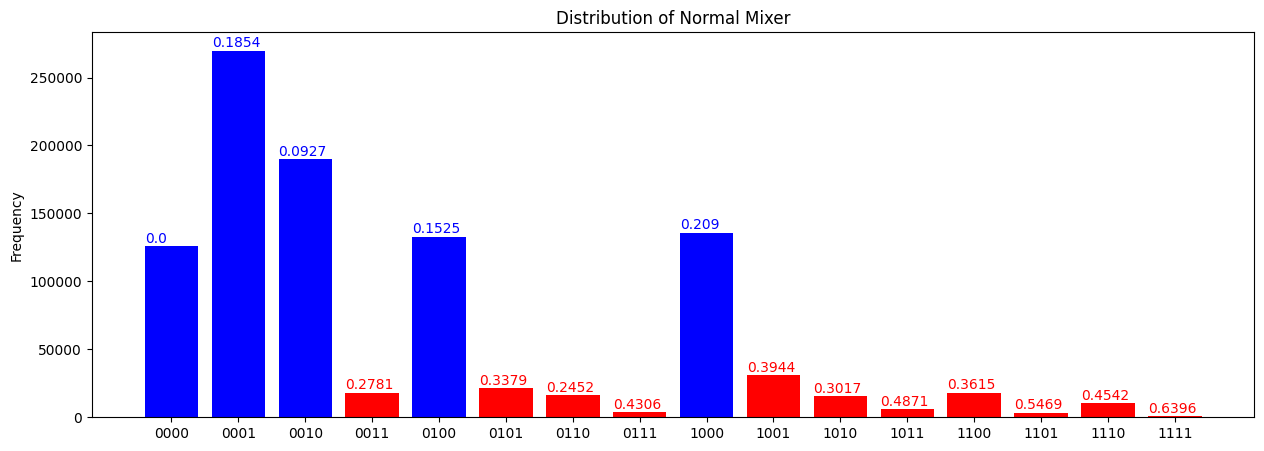

In [19]:
# plt.figure(figsize=(100, 15))
x = np.arange(2**n_qubit)
plt.figure(figsize=(15, 5))

# plt.bar(range(2**qubit_count), list(result.values()))
plt.bar(range(2**n_qubit), result_final, color=colorr)
# plt.bar(range(int(2**(n_qubit-3)*0.1)), result_final[2**(n_qubit-3)*4:int(2**(n_qubit-3)*4.1)])
plt.ylabel('Frequency')
plt.title('Distribution of Normal Mixer')
# plt.gca().set_xticklabels([])
# plt.xticks(rotation=90)
# plt.xticks(visible=False)
# plt.xticks(xlocs, xlabs)
plt.xticks(x, [f"{i:0{n_qubit}b}" for i in x])
xlocs, xlabs = plt.xticks()
# print(xlocs, xlabs)
for i, s in enumerate(ex_ret):
    plt.text(xlocs[i]-0.4, result_final[i]+shots_count/400, s, color=colorr[i])

plt.show()

Expectations file not found for Nelder-Mead
Expectations file not found for COBYLA
Expectations file not found for SPSA
Loading expectations from Adam
Expectations file not found for GradientDescent


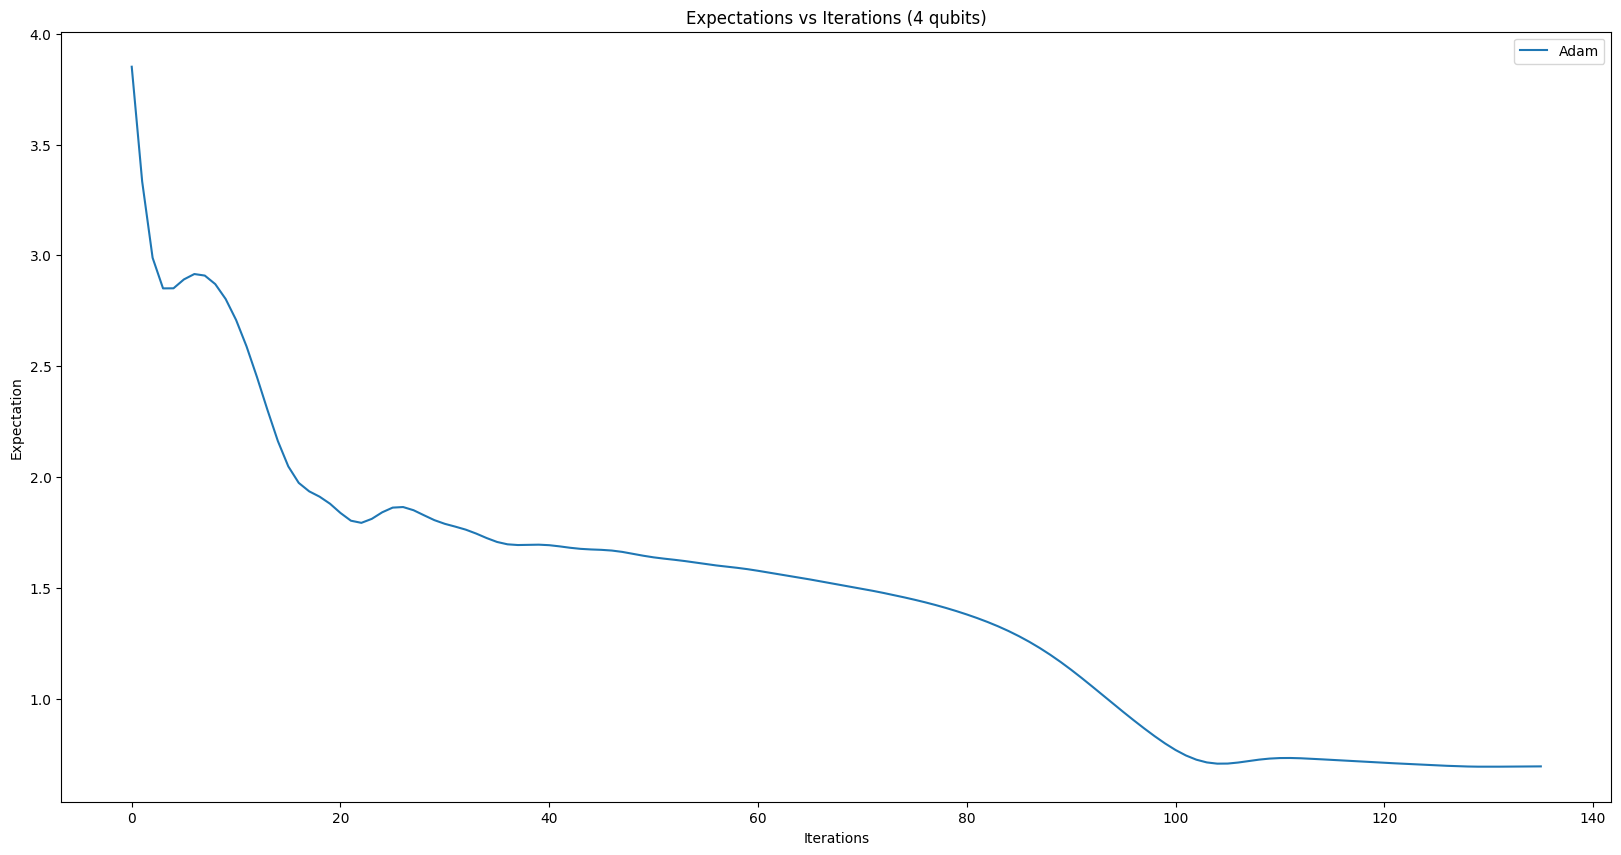

In [20]:
plt.figure(figsize=(20, 10))
for i in range(len(optimizer_names)):
    if os.path.exists(f"./output_PO/expectations_{optimizer_names[i]}.npy"):
        print(f"Loading expectations from {optimizer_names[i]}")
    else:
        print(f"Expectations file not found for {optimizer_names[i]}")
        continue
    expectations = np.load(f"./output_PO/expectations_{optimizer_names[i]}.npy")
    plt.plot(expectations, label=optimizer_names[i])
plt.xlabel('Iterations')
plt.ylabel('Expectation')
plt.title(f'Expectations vs Iterations ({n_qubit} qubits)')
plt.legend()
plt.show()